In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [2]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'go' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [9]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

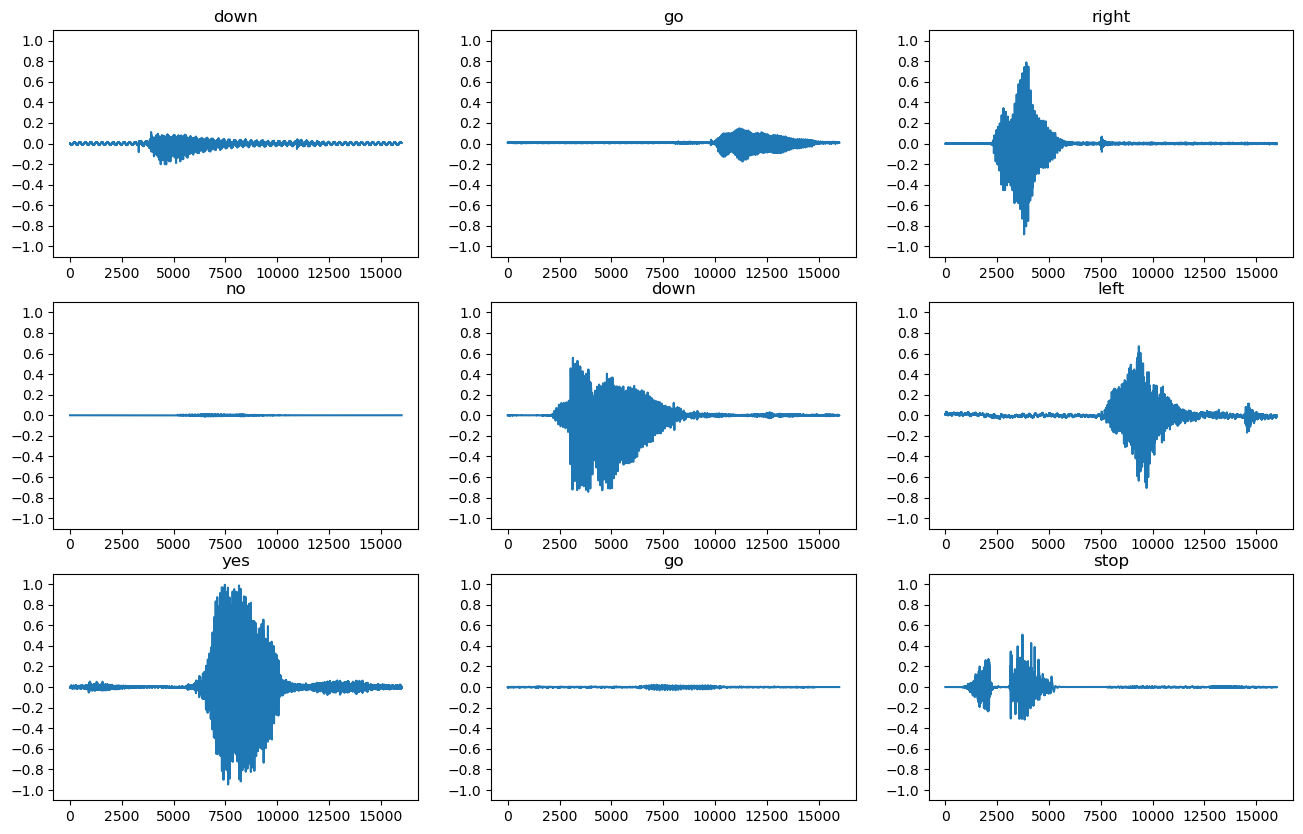

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [11]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [12]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

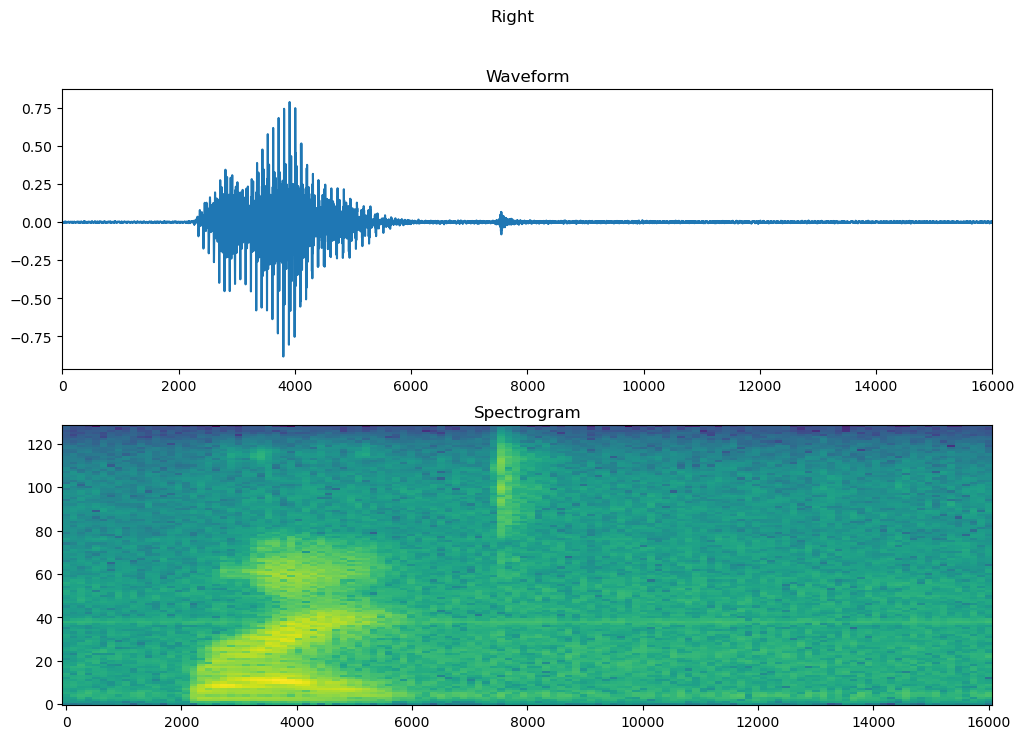

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

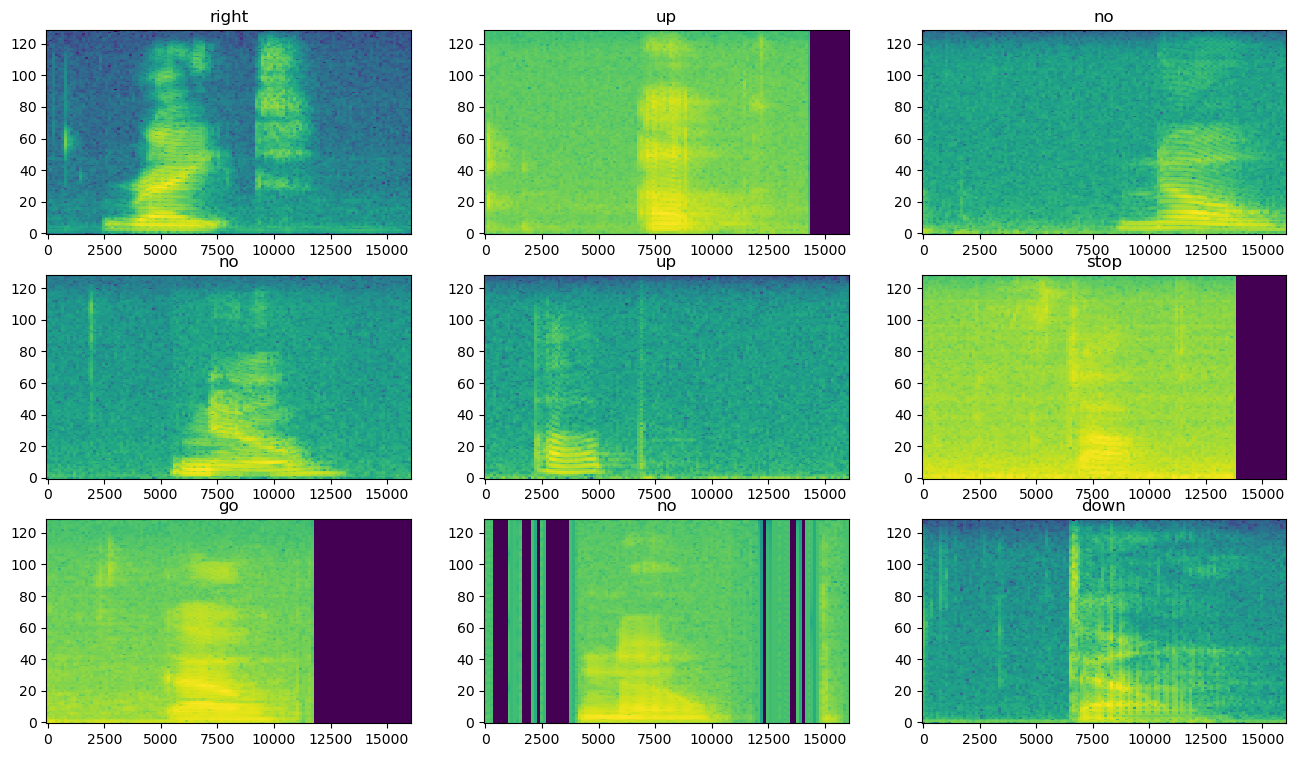

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [18]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [21]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 4s 38ms/step - loss: 1.7375 - accuracy: 0.3872 - val_loss: 1.3039 - val_accuracy: 0.5846
Epoch 2/10
100/100 [==============================] - 3s 34ms/step - loss: 1.1564 - accuracy: 0.5920 - val_loss: 0.9730 - val_accuracy: 0.6549
Epoch 3/10
100/100 [==============================] - 3s 34ms/step - loss: 0.8984 - accuracy: 0.6827 - val_loss: 0.7795 - val_accuracy: 0.7422
Epoch 4/10
100/100 [==============================] - 3s 35ms/step - loss: 0.7210 - accuracy: 0.7358 - val_loss: 0.6556 - val_accuracy: 0.8060
Epoch 5/10
100/100 [==============================] - 3s 34ms/step - loss: 0.6191 - accuracy: 0.7742 - val_loss: 0.5741 - val_accuracy: 0.8242
Epoch 6/10
100/100 [==============================] - 3s 34ms/step - loss: 0.5293 - accuracy: 0.8116 - val_loss: 0.5286 - val_accuracy: 0.8424
Epoch 7/10
100/100 [==============================] - 3s 34ms/step - loss: 0.4925 - accuracy: 0.8216 - val_loss: 0.5319 - val_accuracy: 0.8516

Text(0, 0.5, 'Accuracy [%]')

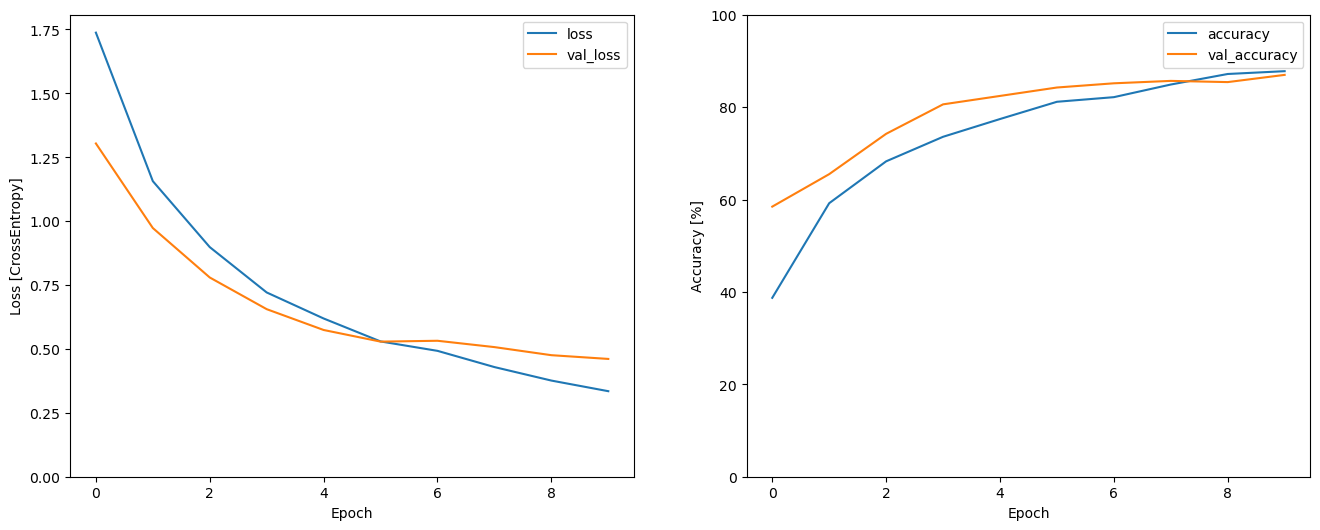

In [22]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [23]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 16ms/step - loss: 0.4826 - accuracy: 0.8377


{'loss': 0.48260578513145447, 'accuracy': 0.8377403616905212}

In [24]:
y_pred = model.predict(test_spectrogram_ds)

y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

13/13 [==============================] - 0s 8ms/step


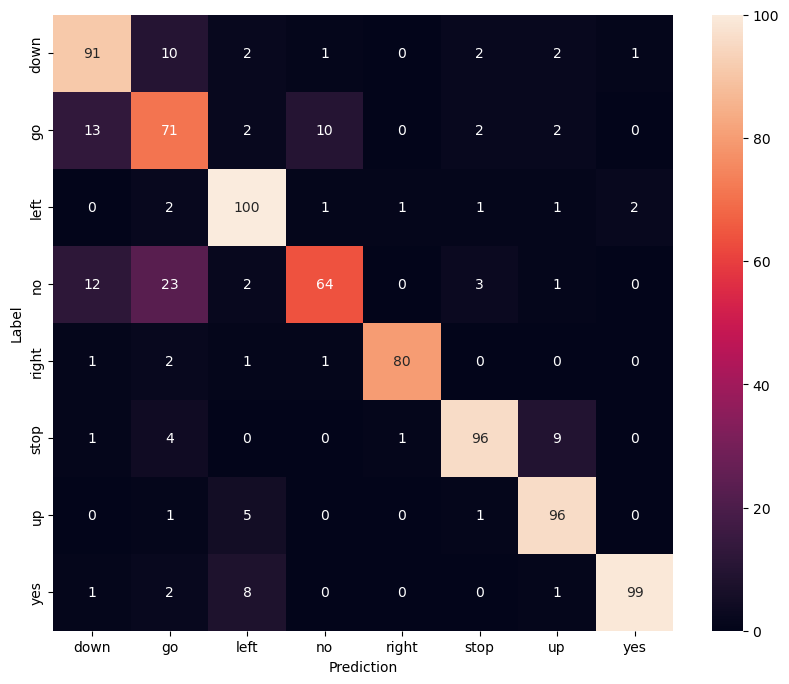

In [25]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

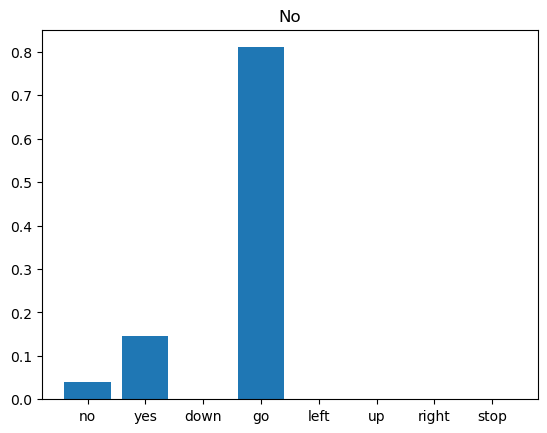

In [26]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [27]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # You could add additional signatures for a single wave, or a ragged-batch. 
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it. 
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)  
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
                'class_ids': class_ids,
                'class_names': class_names}

In [28]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0680497,  2.3688347, -2.4011433,  4.082736 , -4.2415237,
         -2.3689117, -3.4453793, -3.3922   ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [29]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 1.0680497,  2.3688347, -2.4011433,  4.082736 , -4.2415237,
         -2.3689117, -3.4453793, -3.3922   ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}